# Calculating scribal distances
## _How do scribes appropriate the exemplar's text when copying?_

Code accompanying talk presented at _On the way to the future of digital manuscript studies_ (paper on the way)

27-29 October 2021, Radboud Universiteit Nijmegen

### Notebook Overview

1. <a href=#textpreproces>Text preprocessing</a>
2. <a href=#alignment>Alignment (at word-level) with Needleman-Wunsch algorithm</a>
3. <a href=#slicing>Slicing the alignment tables</a>
4. <a href=#feature-extraction>Feature extraction</a>
5. <a href=#distinctivness>Distinctive features</a>
    <br>
    5.1. <a href=#distinctivness>Decision tree visualization</a> <a name='decisiontree'/>
6. <a href=#bootstrap>Bootstrap on slices</a>
7. <a href=#zeta>Zeta for contrastive analysis</a>
    <br>
    7.1. <a href=#zetafull>Zeta for complete manuscripts</a>
    <br>
    7.2. <a href=#zetaspecific>Zeta for specific windows</a>
8. <a href=#ablation>Ablation experiment to check effect of HTR</a>
    <br>
    8.1. <a href=#ablationhtr>Analysis on text recognized with 'bad' HTR-model</a>
    <br>
    8.2. <a href=#ablationartificial>Analysis on text with artificial noise introduced</a>
    <br>
    8.2.1. <a href=#featuredecline>Decline of features</a>
    <br>
    8.2.2. <a href=#bootstrapnoised>Bootstrap on noised samples</a>
----------------

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
from tqdm import tqdm
import pandas as pd
np.random.seed(123123)

## OLD SLICER -- deprecated, just for reference

The issue: if you split the text into e.g. 100 slices, only the first 10 will align. Most slices do not align. Therefore, we cannot compare them with each other. See folder `data/naive_slices`: each file is an alignment table of the slices generated with the code below. `slice_1.xlsx` contains the first slice, `slice_2.xlsx` the second slice, etc. for A and B aligned. If you look at `slice_13.xlsx`, you will see that there is virtually no match anymore between the slices.

```python

def load_slices(path, num_slices, slice_len=None):
    with open(path) as f:
        text = f.read()
    text = text.replace('- ', '')
    text = ' '.join(text.split())
    n = len(text) // num_slices
    slices = [text[i:i+n] for i in range(0, len(text), n) if i+n <= len(text)]
    return slices

num_slices = 100 # default: 100
A = load_slices('copies/A.txt', num_slices=num_slices)
B = load_slices('copies/B.txt', num_slices=num_slices)
```

### 1. Text preprocessing <a name='textpreproces'/>

In [201]:
# simple text preprocessing, splitting tokens on whitespace

def preprocess_txt(path):
    with open(path) as f:
        text = f.read()
        text = [' '.join(text.split())]
    return text

# alignment algortihm is computationally very demanding, so: feed text chunks no larger than 50kb 
A = preprocess_txt('data/copies/A/A.txt')
B = preprocess_txt('data/copies/B/B.txt')

### 2. Performing alignment (at word-level) with Needleman-Wunsch algorithm <a name='alignment'/>

Alignment is pursued in order to ensure that our analyses occur at matching parts in the oeuvre of Hadewijch. Using a naive, index-based (e.g. cutting up slices at similar character indices), we run the risk that text slices don't really overlap content-wise. Running the Needleman-Wunsh alignment algorithm on the two texts under investigation, and _then_ cutting up the text in slices, we are confident that the textual analysis (i.e. extracting textual features) takes place at textually similar portions of Hadewijch's oeuvre. The implementation of the Needleman-Wunsch algorith employed here, was developed by Folgert Karsdorp: https://github.com/fbkarsdorp/alignment

In [202]:
# dry run of the alignment algorithm, using first 100 characters of Hadewijch manuscript A and B
# comment out this code block, if you want to perform the alignment on the entire text (i.e. preprocessed A and B from the code block above)

A_test = ['GOd die de clare Mᵉ die onbekint was vʼclaerde bi siere doghꝫ daer hi alle doghꝫ bi vʼlichte in siere claerheit der Mⁿ']
B_test = ['GOd die de clare Mᵉ die onbekint was ꝟclaerde bi siere doget . Daʼ hi alle doghet bi verlichte in siere claerheit der mīnen .']

In [5]:
from alignment import align_sequences
from alignment import Alignment

from alignment.utils import merge

cnt = 0

for variant_A, variant_B in zip(A_test, B_test): # change (A_test, B_test) to (A, B) if you want to run alignment on full texts 
    cnt += 1
    print('==== Alignment ', cnt, "====")
    sequence_a = variant_A.split()
    sequence_b = variant_B.split() # discard .split() if you want to perform aligmnent at character level (computationally very heavy)

    # align the two sequences
    align_a, align_b, distance = align_sequences(sequence_a, sequence_b)
    
    # construct a new Alignment object
    alignment = Alignment.from_sequences(align_a, align_b)
    
    # get pandas dataframe
    df = alignment.to_df()
    
    file_name = f'hadewijch_NOISY_3.xlsx'
  
    # saving the excelsheet
    df.to_excel(file_name)
    print(f'Alignment {cnt} successfully exported to Excel File')

    # pretty print the alignment
    print(alignment)
    
    # get alignment score
    print(alignment.score())

==== Alignment  1 ====
Alignment 1 successfully exported to Excel File
     0    1   2      3   4    5         6    7          8   9     10     11     12    13  14    15      16  17         18  19     20         21   22     23  24
0  GOd  die  de  clare  Mᵉ  die  onbekint  was  vʼclaerde  bi  siere      _  doghꝫ  daer  hi  alle   doghꝫ  bi   vʼlichte  in  siere  claerheit  der      _  Mⁿ
1  GOd  die  de  clare  Mᵉ  die  onbekint  was   ꝟclaerde  bi  siere  doget      .   Daʼ  hi  alle  doghet  bi  verlichte  in  siere  claerheit  der  mīnen   .
0.32


### 3. Slice the alignment table into equal parts <a name='slicing'/>

We now slice up the texts, according to matching token indices. If, e.g, we would take 10-token slices from the example above, we would obtain the following two slices for each text:

A_1: _GOd_ -> _bi_ \
B_1: _GOd_ -> _bi_

A_2: _siere_ -> _in_ \
B_2: _siere_ -> _in_

For our analyses, we take slices of ca. 1000 tokens. This means that we have to divide Hadewijch's oeuvre into 75 parts.

In [106]:
# set the number of slices you want to take from the alignment table
num_slices = 75

In [107]:
import numpy as np
import pandas as pd

# read alignment table
df = pd.read_excel("data/alignment_tables/Had_A_B_aligned.xlsx")

# transpose (if needed; the provided table `hadewijch_aligned.xlsx` is already transposed)
#df = df.T

# disregard first row (which contains integers)
#df = df.iloc[1:]

df.rename(columns = {0:'A', 1:'B'}, inplace = True)

# slice into n equal parts
print('Approx. number of tokens:', len(df))

chunks = np.array_split(df, num_slices)

A = []
B = []
slice_n = 1
for chunk in chunks:
    print("Slice number:", slice_n)
    slice_n+=1
    chunk_a = chunk['A'].tolist()
    chunk_b = chunk['B'].tolist()
    
    chunk_a = [elem for elem in chunk_a if elem != "_"] # delete placeholder when there is no alignment
    chunk_a = [elem for elem in chunk_a if str(elem) != 'nan'] # delete weird NaN artefact (very rare!)
    chunk_b = [elem for elem in chunk_b if elem != "_"]
    chunk_b = [elem for elem in chunk_b if str(elem) != 'nan']
    
    print("A", "\t", len(chunk_a), "\t", "START -", chunk_a[:5], "\n\t\t", "END -", chunk_a[-5:])
    print("B", "\t", len(chunk_b), "\t", "START -", chunk_b[:5], "\n\t\t", "END -", chunk_b[-5:])
    print("----------------")

    A.append(chunk_a)
    B.append(chunk_b)
    
# flatten list of list of strings to list of strings
#print("Text", "\t", "Slice lenght (# of tokens)", "\t",)
A = [' '.join(elem) for elem in A]
B = [' '.join(elem) for elem in B]

Approx. number of tokens: 82871
Slice number: 1
A 	 1055 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['hoeden', 'soe', 'dat', 'ghijt', 'ghenadech']
B 	 1049 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['seluē', 'hoedē', 'soe', 'dat', 'ghijt']
----------------
Slice number: 2
A 	 1070 	 START - ['leke', 'goet', 'doē', 'hebbꝫ', 'wildijt'] 
		 END - ['rechter', 'caritatē', 'behort', 'in', 'ordenē']
B 	 1063 	 START - ['ghenadechleec', 'goetdoē', 'hebbet', 'wildijt', 'bekīnen'] 
		 END - ['gherechter', 'caritatē', 'behort', 'in', 'ordenē']
----------------
Slice number: 3
A 	 1063 	 START - ['Hier', 'in', 'moghedi', 'volmaect', 'wʼdē'] 
		 END - ['op', 'gheuē', 'wilt', 'vore', 'sinē']
B 	 1076 	 START - ['Hier', 'in', 'moegdi', 'volmaect', 'wʼdē'] 
		 END - ['op', 'geuē', 'wilt', 'vore', 'sinē']
----------------
Slice number: 4
A 	 1073 	 START - ['tijt', 'En̄', 'te', 'meneghē', 'vrēden'] 
		 END - ['daer', 'om̅e', 'ellende', 'en̄', 'menech']
B 	 1077 	 START - ['ti

In [108]:
# sanity check, making sure A and B are cut up in equal windows
len(A) == len(B)
#print(A[20])
#print(B[20])

True

### 4. Feature extraction <a name='feature-extraction'/>
Distinctive features are extracterd from the texts, based on their frequency. The vectorizer used for this is the `TfidfVectorizer` (with the idf-option turned off; so what is returned are relative frequencies in the slices for these features). By default, we run our analyses at a character-level. This means that we take a specified number (e.g. 1000) of high-frequency sequences of characters as features from the complete texts. These character-sequences, as specified in the `ngram_range`, take the form of trigrams, fourgrams and fivegrams. 

For analyses at the word-level, the `analyzer` can be set to `word`. In this case, it is advised to set the `ngram_range` to `1`.

In [109]:
# define the number of features to extract (these features are extracted)
num_features = 1000 # default: 1000
vec = TfidfVectorizer(max_features=num_features, use_idf=False, ngram_range=(4, 5), analyzer='char')
#vec = CountVectorizer(max_features=num_features, ngram_range=(1, 1), analyzer='word')

In [110]:
# features extracted from both texts
vec.fit(A + B)
print(vec.get_feature_names()[:100])

[' . a', ' . d', ' . da', ' . di', ' . e', ' . en', ' . h', ' . s', ' . w', ' .i.', ' .i. ', ' al ', ' al d', ' all', ' alle', ' alr', ' alre', ' als', ' alse', ' also', ' alt', ' alto', ' and', ' ane', ' ane ', ' ay ', ' beg', ' begh', ' beh', ' bek', ' bes', ' bi ', ' bli', ' bou', ' dae', ' daer', ' dan', ' dan ', ' dat', ' dat ', ' dats', ' de ', ' de m', ' der', ' der ', ' des', ' di ', ' die', ' die ', ' dien', ' dies', ' din', ' dit', ' dit ', ' diē', ' doe', ' doe ', ' doet', ' dog', ' dē ', ' dʼ ', ' dʼ i', ' dʼ m', ' en ', ' en w', ' end', ' ende', ' ene', ' en̄', ' en̄ ', ' es ', ' es d', ' gee', ' gen', ' geno', ' geu', ' ghe', ' gheb', ' ghee', ' ghel', ' ghen', ' gher', ' ghes', ' gheu', ' ghew', ' ghi', ' ghi ', ' god', ' god ', ' gode', ' goe', ' gro', ' grot', ' had', ' hadd', ' hae', ' haer', ' har', ' hare', ' haʼ']


In [111]:
A_ = vec.transform(A).toarray()
B_ = vec.transform(B).toarray()
print(A_.shape, B_.shape)

(75, 1000) (75, 1000)


In [112]:
# get df's for features per sample
df_A_ = pd.DataFrame(A_, columns = vec.get_feature_names())
df_B_ = pd.DataFrame(B_, columns = vec.get_feature_names())
df_A_#.T.loc['zij']

,. a,. d,. da,. di,. e,. en,. h,. s,. w,.i.,...,ʼ mⁿ,ʼ mⁿ,̄ al,̄ da,̄ dat,̄ di,̄ die,̄ in,̄ in,̄ si
0,0.016213,0.043234,0.032425,0.005404,0.054042,0.048638,0.021617,0.021617,0.021617,0.005404,...,0.005404,0.005404,0.027021,0.005404,0.000000,0.005404,0.005404,0.005404,0.005404,0.016213
1,0.020260,0.075974,0.035455,0.020260,0.035455,0.030390,0.005065,0.025325,0.010130,0.000000,...,0.020260,0.020260,0.005065,0.015195,0.010130,0.005065,0.005065,0.005065,0.005065,0.000000
2,0.009895,0.034632,0.014842,0.009895,0.004947,0.000000,0.019790,0.004947,0.000000,0.000000,...,0.009895,0.009895,0.000000,0.044527,0.034632,0.019790,0.019790,0.009895,0.009895,0.004947
3,0.004902,0.034317,0.019610,0.014707,0.004902,0.004902,0.000000,0.004902,0.019610,0.000000,...,0.014707,0.014707,0.009805,0.014707,0.009805,0.009805,0.004902,0.000000,0.000000,0.009805
4,0.015064,0.050214,0.030129,0.010043,0.020086,0.010043,0.010043,0.005021,0.010043,0.000000,...,0.010043,0.010043,0.050214,0.025107,0.020086,0.035150,0.015064,0.000000,0.000000,0.005021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.000000,0.000000,0.000000,0.000000,0.005413,0.005413,0.000000,0.000000,0.000000,0.027065,...,0.059543,0.059543,0.010826,0.021652,0.021652,0.005413,0.005413,0.000000,0.000000,0.000000
71,0.000000,0.000000,0.000000,0.000000,0.010585,0.005292,0.005292,0.000000,0.000000,0.021170,...,0.042339,0.042339,0.010585,0.021170,0.021170,0.005292,0.005292,0.021170,0.021170,0.010585
72,0.004893,0.000000,0.000000,0.000000,0.014680,0.014680,0.004893,0.004893,0.000000,0.029361,...,0.039148,0.039148,0.024467,0.000000,0.000000,0.000000,0.000000,0.009787,0.009787,0.004893
73,0.000000,0.016842,0.005614,0.000000,0.005614,0.005614,0.000000,0.000000,0.000000,0.011228,...,0.039297,0.039297,0.005614,0.005614,0.005614,0.000000,0.000000,0.000000,0.000000,0.000000


### 5. Distinctive features (overall) <a name='distinctivness'/>

In order to get an idea of feature importance, we can measure their distinctiveness in a tree-based model, such as a Random Forest Classifier.

In scikit-learn, Mean Decrease Impurity (MDI) is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node) averaged over all trees of the ensemble. Cfr. [Leo Breiman et al., _Classification and regression trees_, 1984](https://doi.org/10.1201/9781315139470).

In order to understand Mean Decrease Impurity, it is important first to understand Gini Impurity, which is a metric used in Decision Trees to determine how (using which variable, and at what threshold) to split the data into smaller groups. Gini Impurity measures how often a randomly chosen record from the data set used to train the model will be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset (e.g., if half of the records in a group are "A" and the other half of the records are "B", a record randomly labeled based on the composition of that group has a 50% chance of being labeled incorrectly). Gini Impurity reaches zero when all records in a group fall into a single category (i.e., if there is only one possible label in a group, a record will be given that label 100% of the time). This measure is essentially the probability of a new record being incorrectly classified at a given node in a Decision Tree, based on the training data. 
 
Because Random Forests are an ensemble of individual Decision Trees, Gini Importance can be leveraged to calculate Mean Decrease in Gini, which is a measure of variable importance for estimating a target variable. Mean Decrease in Gini is the average (mean) of a variable’s total decrease in node impurity, weighted by the proportion of samples reaching that node in each individual decision tree in the random forest. This is effectively a measure of how important a variable is for estimating the value of the target variable across all of the trees that make up the forest. A higher Mean Decrease in Gini indicates higher variable importance. Variables are sorted and displayed in the Variable Importance Plot created for the Random Forest by this measure. The most important variables to the model will be highest in the plot and have the largest Mean Decrease in Gini Values, conversely, the least important variable will be lowest in the plot, and have the smallest Mean Decrease in Gini values.

(taken from https://community.alteryx.com/t5/Alteryx-Designer-Discussions/Help-Mean-Decrease-in-Gini-for-dummies/td-p/197223)

In [113]:
from sklearn.ensemble import RandomForestClassifier

feature_names = vec.get_feature_names()
forest = RandomForestClassifier(random_state=0)
forest.fit(np.vstack((A_, B_)),  list('A' * num_slices + 'B' * num_slices))

RandomForestClassifier(random_state=0)

In [114]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [115]:
topn = 25 # default: 20
idxs = np.argsort(importances)[::-1][:topn]

In [116]:
importances = importances[idxs]
std = std[idxs]
names = np.array(vec.get_feature_names())[idxs]
forest_importances = pd.Series(importances, index=names)

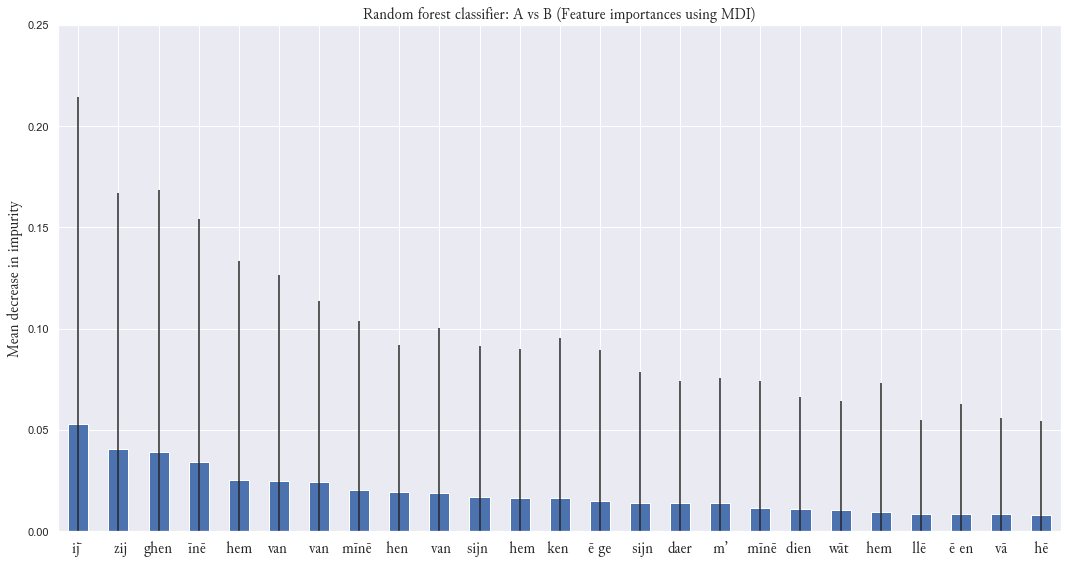

In [117]:
forest_importances = pd.Series(importances, index=names)
sns.set_theme()

# set junicode font for labels (able to render medieval glyphs)
font = {'family': 'Junicode',
        'size': 15,
        }

fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(yerr=std, ax=ax, rot=0)
ax.set_title("Random forest classifier: A vs B (Feature importances using MDI)", fontdict=font)
ax.set_ylabel("Mean decrease in impurity", fontdict=font)
ax.set_xticklabels(names, fontdict=font)
#ax.set_yticklabels(importances, fontdict=font)
ax.set_ylim((0, .25))
fig.tight_layout()
plt.savefig('gfx/features_importance_mdi.png', transparent=False, dpi=300)

#### 5.1. Visualisation of Decision Tree (for reference in article) <a name='decisiontree'/>
See:
- https://explained.ai/decision-tree-viz/index.html
- https://github.com/parrt/dtreeviz
- https://github.com/parrt/dtreeviz/blob/master/notebooks/examples.ipynb
- https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7
- https://alexisperrier.com/datascience/2015/08/27/feature-importance-random-forests-gini-accuracy.html

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from dtreeviz.trees import dtreeviz

# put data in one variable
data = np.vstack((A_, B_)),  np.array(list('A' * num_slices + 'B' * num_slices))

X = data[0] # features
y = data[1] # labels

X_inst = data[0][np.random.randint(0, len(data[0])),:]
#print(X_inst)


lb = LabelEncoder()
y2 = lb.fit_transform(y)
y_series = pd.Series(y2) # y must be a Pandas series of integers! This is why we're transforming it with the LabelEncoder!

rf = RandomForestClassifier(n_estimators=100,
                            max_depth=3,
                            max_features=100,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            random_state=0)

rf.fit(X, y)

tree_n=50

viz = dtreeviz(rf.estimators_[tree_n], X, y_series, # change the estimator number to get a different decision tree
               target_name="Hadewijch Manuscript",
               feature_names=feature_names,
               class_names=['A', 'B'],
               title=f"{tree_n+1}th decision tree for scribal features",
               fontname='Junicode',
               fancy=True, 
               X=X_inst,
               orientation='LR')

viz.save(f"gfx/decision_trees/decision_tree_{tree_n+1}.svg")
#from google.colab import files
#files.download("decision_tree.svg")

<img src="gfx/decision_trees/decision_tree_example.png" alt="Example of decision tree" style="width: 670px"/>

### 6. Bootstrap on slices <a name='bootstrap'/>

Gentle introductions, and intution behind bootstrapping, see: 

- https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/#:~:text=The%20bootstrap%20method%20is%20a,the%20mean%20or%20standard%20deviation
- https://www.analyticsvidhya.com/blog/2020/02/what-is-bootstrap-sampling-in-statistics-and-machine-learning/
- https://www.mastersindatascience.org/learning/introduction-to-machine-learning-algorithms/bootstrapping/
- https://towardsdatascience.com/what-is-bootstrap-sampling-in-machine-learning-and-why-is-it-important-a5bb90cbd89a

In [119]:
num_boot_features = int(.5 * num_features) # analysis run on half of the number of features
num_bootstraps = 500

In [120]:
distances = []

for idx in tqdm(range(len(A_))):
    d = []
    for _ in range(num_bootstraps):
        rnd_idxs = np.random.choice(range(num_features), size=num_boot_features, replace=False)
        d.append(distance.cosine(A_[idx, rnd_idxs], B_[idx, rnd_idxs]))
    distances.append((idx + 1,
                      np.quantile(d, 0.05),
                      np.quantile(d, 0.50),
                      np.quantile(d, 0.95)
                     ))

100%|██████████| 75/75 [00:06<00:00, 11.23it/s]


In [121]:
df = pd.DataFrame(distances, columns=('position', 'q05', 'q50', 'q95'))
df

,position,q05,q50,q95
0,1,0.059375,0.075692,0.098251
1,2,0.053188,0.068594,0.084766
2,3,0.036541,0.047893,0.064837
3,4,0.049695,0.065635,0.089055
4,5,0.038473,0.050434,0.066074
...,...,...,...,...
70,71,0.106145,0.147414,0.185804
71,72,0.097180,0.127600,0.173071
72,73,0.159508,0.211500,0.280922
73,74,0.078338,0.099784,0.129187


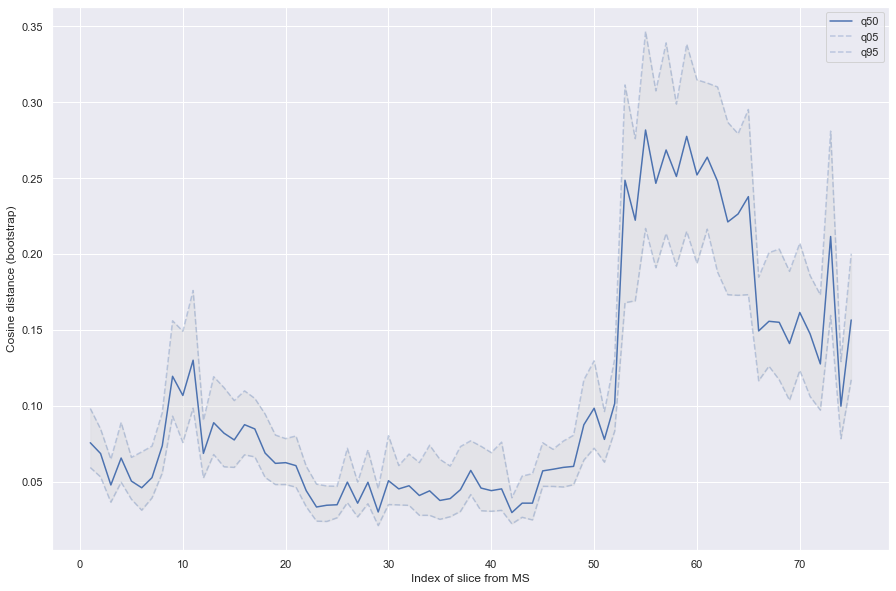

In [122]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.legend();
plt.savefig('gfx/distance_B_A_noisy.pdf', transparent=False)

In [123]:
d = np.polyfit(df['position'], df['q50'], 1)
f = np.poly1d(d)
df['pred'] = f(df['position'])

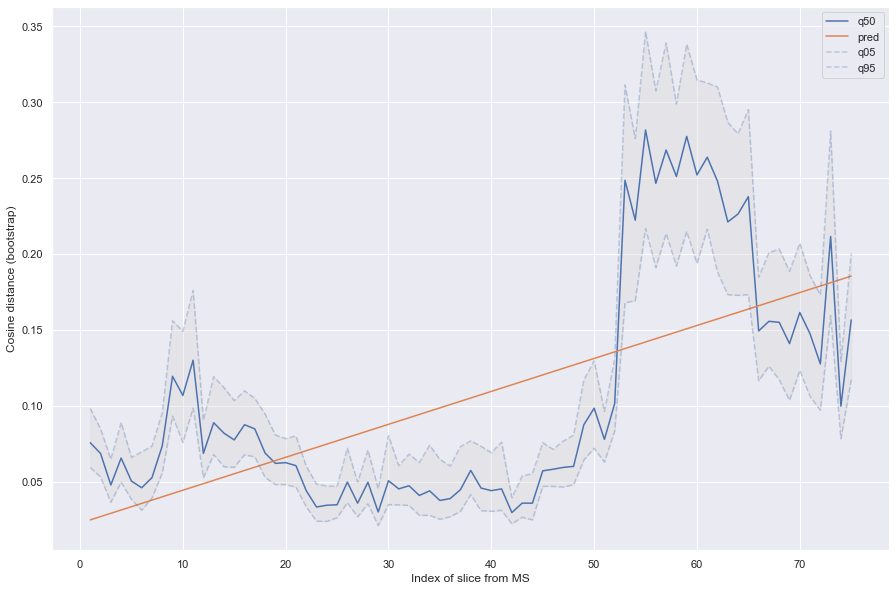

In [124]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='pred', ax=ax, figsize=(15,10), color='C1')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.legend();
plt.savefig('gfx/distance_regression.pdf', transparent=False)
plt.savefig('gfx/distance_regression.png', transparent=False, dpi=300)

In [125]:
for idx, a in enumerate(A):
    if 'HEt was in ene sōdage' in a:
        start_visions = idx
    if 'AY al es nu die winter cout' in a:
        start_songs = idx
    if 'eens beide bliuen Ja' in a:
        start_scribe2 = idx
    if 'DJt nuwe iaer es ons begōnē' in a:
        start_scribe3 = idx
    if 'GOd si mꝫ v van mier groetene' in a:
        start_poems = idx

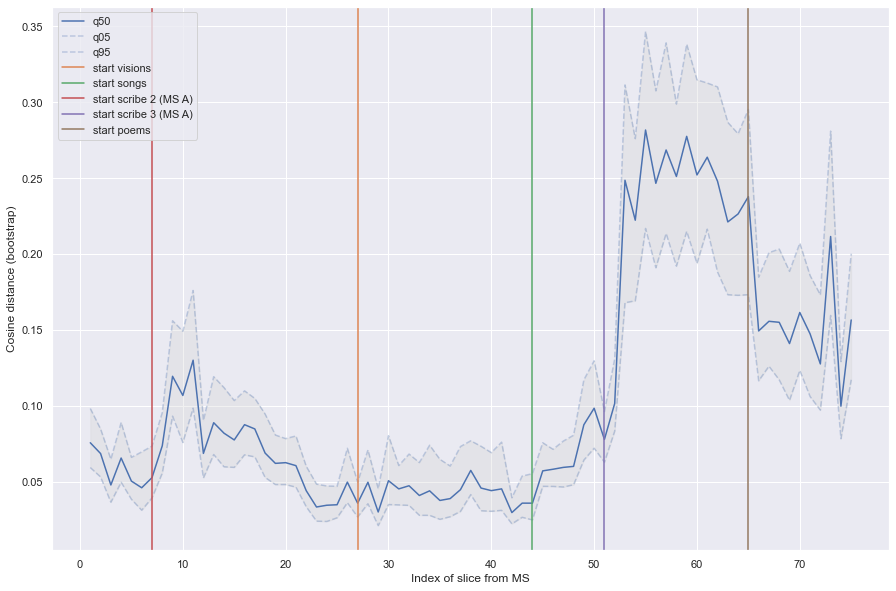

In [126]:
ax = df.plot(x='position', y='q50', figsize=(15,10), color='C0')
df.plot(x='position', y='q05', ax=ax, color='C0', ls='--', alpha=0.3)
df.plot(x='position', y='q95', ax=ax, color='C0', ls='--', alpha=0.3)
ax.fill_between(df['position'], df['q05'], df['q95'], color='lightgrey', alpha=0.3);
ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.axvline(start_visions, color='C1', label='start visions')
plt.axvline(start_songs, color='C2', label='start songs')
plt.axvline(start_scribe2, color='C3', label='start scribe 2 (MS A)')
plt.axvline(start_scribe3, color='C4', label='start scribe 3 (MS A)')
plt.axvline(start_poems, color='C5', label='start poems')

plt.legend();
plt.savefig('gfx/distance_bars.pdf', transparent=False)
plt.savefig('gfx/distance_bars.png', transparent=False, dpi=300)

### 7. Calculating Zeta for contrastive analysis <a name='zeta'/>

**References**: 

Burrows, J. F. (2007). *All the way through: testing for authorship in different frequency strata*. "Literary and Linguistic Computing", 22(1): 27-48.

Craig, H. and Kinney, A. F., eds. (2009). *Shakespeare, Computers, and the Mystery of Authorship*. Cambridge: Cambridge University Press.

#### 7.1. Zeta for full manuscripts <a name='zetafull'/>

In [131]:
from nltk import word_tokenize
import re

def segment(text):
    token_pattern = re.compile(r"(?u)\b\w+\b")
    tokens = [w.lower() for w in token_pattern.findall(text)]
    tokens_clean = [item for i,item in enumerate(tokens)]
    return tokens_clean


a_docs = []
for idx, a in enumerate(A):
    a_doc = segment(a)
    a_docs.append(a_doc)
    
b_docs = []
for idx, b in enumerate(B):
    b_doc = segment(b)
    b_docs.append(b_doc)
    
from sklearn.feature_extraction.text import CountVectorizer

zeta_vectorizer = CountVectorizer(max_features=150, # original: CountVectorizer
                                  analyzer=lambda x: x,
                                  binary=True)

zeta_vectorizer.fit(a_docs + b_docs)
zeta_vocab = zeta_vectorizer.get_feature_names()

_a = zeta_vectorizer.transform(a_docs).toarray()
_b = zeta_vectorizer.transform(b_docs).toarray()

n_a = _a.shape[0]
n_b = _b.shape[0]
print(f'Number of A-segments: {n_a}')
print(f'Number of B-segments: {n_b}')

Number of A-segments: 75
Number of B-segments: 75


In [132]:
dp_a = _a.sum(axis=0) / n_a
dp_b = _b.sum(axis=0) / n_b

Z = dp_a - dp_b

In [133]:
import numpy as np
ranked = [(zeta_vocab[idx], Z[idx]) for idx in np.argsort(Z)]

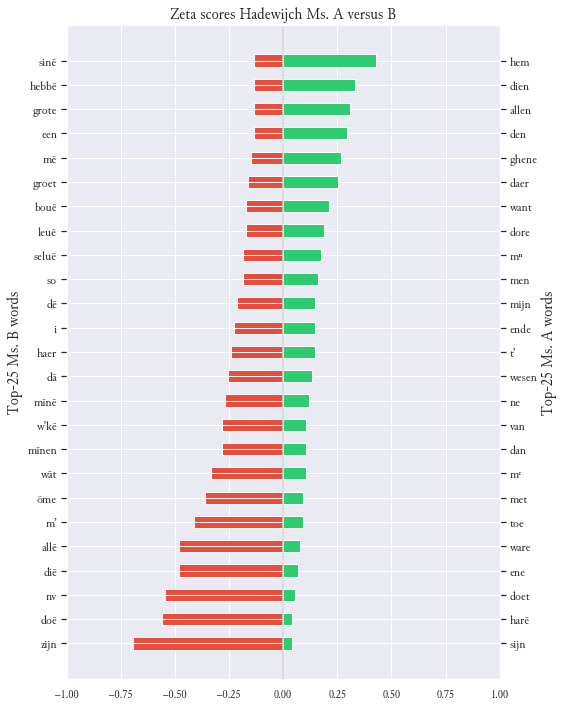

In [134]:
sns.set(font="Junicode")

width = .50
m = 25

fig = plt.figure(figsize=(8, 10))

b_labels, b_scores = zip(*ranked[:m])
a_labels, a_scores = zip(*ranked[-m:])

pos = np.arange(m) - (width / 2)

ax1 = fig.add_subplot(111)
plt.barh(pos, b_scores, width, color="#e74c3c")
plt.yticks(pos, b_labels, fontsize = 12)
ax1.set_ylabel(f'Top-{m} Ms. B words', fontsize = 15)

ax2 = ax1.twinx()
ax2.barh(pos, a_scores, width, color='#2ecc71')
ax2.set_yticks(pos)
ax2.set_yticklabels(a_labels, fontsize = 12)

plt.xlim((-1, + 1))
plt.axvline(0, color='lightgrey')
ax2.set_ylabel(f'Top-{m} Ms. A words', fontsize = 15)
plt.xlabel('Zeta scores', fontdict=font)
plt.title(f'Zeta scores Hadewijch Ms. A versus B', fontdict=font)
plt.tight_layout()
plt.savefig(f'gfx/zeta.png', dpi=300)

#### 7.2. Zeta for specific *_windows_* <a name='zetaspecific'/>

In [135]:
# window to perform Zeta for
windows_of_interest = [69, 70, 71, 72, 73, 74]

from nltk import word_tokenize
import re

def segment(text):
    token_pattern = re.compile(r"(?u)\b\w+\b")
    tokens = [w.lower() for w in token_pattern.findall(text)]
    tokens_clean = [item for i,item in enumerate(tokens)]
    return tokens_clean

a_docs = []
for idx in windows_of_interest:
    a_doc = segment(A[idx])
    a_docs.append(a_doc)
    
b_docs = []
for idx in windows_of_interest:
    b_doc = segment(B[idx])
    b_docs.append(b_doc)

from sklearn.feature_extraction.text import CountVectorizer

zeta_vectorizer = CountVectorizer(max_features=100,
                                  analyzer=lambda x: x,
                                  binary=True)

zeta_vectorizer.fit(a_docs + b_docs)
zeta_vocab = zeta_vectorizer.get_feature_names()

_a = zeta_vectorizer.transform(a_docs).toarray()
_b = zeta_vectorizer.transform(b_docs).toarray()

n_a = _a.shape[0]
n_b = _b.shape[0]
print(f'Number of A-segments: {n_a}')
print(f'Number of B-segments: {n_b}')

Number of A-segments: 6
Number of B-segments: 6


In [136]:
dp_a = _a.sum(axis=0) / n_a
dp_b = _b.sum(axis=0) / n_b

Z = dp_a - dp_b

import numpy as np
ranked = [(zeta_vocab[idx], Z[idx]) for idx in np.argsort(Z)]

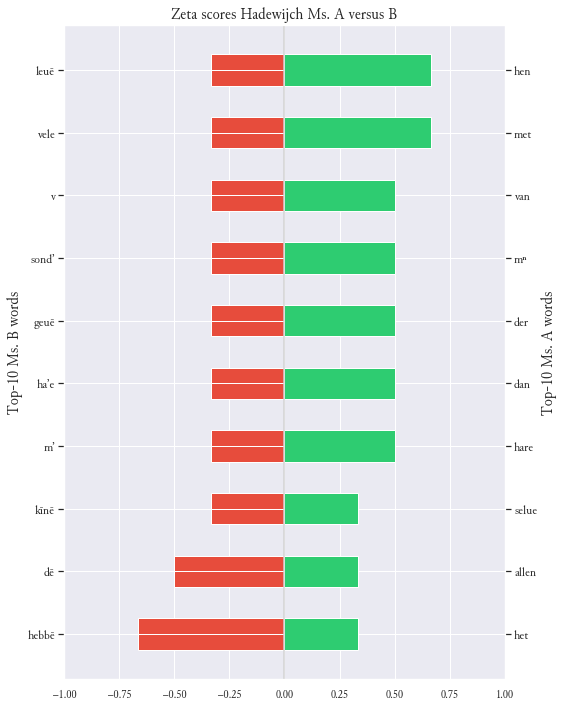

In [137]:
sns.set(font="Junicode")

width = .50
m = 10

fig = plt.figure(figsize=(8, 10))

b_labels, b_scores = zip(*ranked[:m])
a_labels, a_scores = zip(*ranked[-m:])
pos = np.arange(m) - (width / 2)

ax1 = fig.add_subplot(111)
plt.barh(pos, b_scores, width, color="#e74c3c")

plt.yticks(pos, b_labels, fontsize = 12)
ax1.set_ylabel(f'Top-{m} Ms. B words', fontsize = 15)

ax2 = ax1.twinx()
ax2.barh(pos, a_scores, width, color='#2ecc71')
ax2.set_yticks(pos)
ax2.set_yticklabels(a_labels, fontsize = 12)

plt.xlim((-1, + 1))
plt.axvline(0, color='lightgrey')
ax2.set_ylabel(f'Top-{m} Ms. A words', fontsize = 15)
plt.xlabel('Zeta scores', fontdict=font)
plt.title(f'Zeta scores Hadewijch Ms. A versus B', fontdict=font)
plt.tight_layout()
plt.savefig(f'gfx/zeta_specific_windows.png', dpi=300)

### 8. Ablation experiment <a name='ablation'/>

#### 8.1. Analysis with 'bad' HTR-model (i.e. HTR-performance-related noise introduction) <a name='ablationhtr'/>

In [138]:
def input_for_fastwer(path): 
    with open(path) as file:
        lines = file.readlines()
        list_lines = [line.rstrip() for line in lines]
    return list_lines

lines_clean_A = input_for_fastwer("data/copies/noisy_experiment/A_letters_clean.txt")
lines_noisy_A = input_for_fastwer("data/copies/noisy_experiment/A_letters_noisy.txt")

lines_clean_B = input_for_fastwer("data/copies/noisy_experiment/B_letters_clean.txt")
lines_noisy_B = input_for_fastwer("data/copies/noisy_experiment/B_letters_noisy.txt")

# text files are compared at the line-level (so: a quick check to 
print(len(lines_clean_B) == len(lines_noisy_B)) and (len(lines_clean_A) == len(lines_noisy_A))

True


In [139]:
# first, install the necessary packages
!pip install pybind11
!pip install fastwer # https://github.com/kahne/fastwer

In [140]:
import fastwer

print("+"*10, "A", "+"*10)
print('Corpus-Level CER', (fastwer.score(lines_noisy_A, lines_clean_A, char_level=True)))
print('Corpus-Level WER', (fastwer.score(lines_noisy_A, lines_clean_A)))

print("+"*10, "B", "+"*10)
print('Corpus-Level CER', (fastwer.score(lines_noisy_B, lines_clean_B, char_level=True)))
print('Corpus-Level WER', (fastwer.score(lines_noisy_B, lines_clean_B)))


++++++++++ A ++++++++++
Corpus-Level CER 6.9142
Corpus-Level WER 19.125
++++++++++ B ++++++++++
Corpus-Level CER 7.6311
Corpus-Level WER 21.4984


In [141]:
#from IPython.display import HTML
#HTML(filename="gfx/report_A.html")

In [142]:
# set the number of slices you want to take from the alignment table
num_slices = 25

import numpy as np
import pandas as pd

def chunker(aligment_table_path):

    # read alignment table
    df = pd.read_excel(aligment_table_path)

    # transpose (if needed; the provided table `hadewijch_aligned.xlsx` is already transposed)
    #df = df.T

    # disregard first row (which contains integers)
    #df = df.iloc[1:]

    df.rename(columns = {0:'A', 1:'B'}, inplace = True)
    # Slice into n equal parts

    print('Approx. number of tokens:', len(df))

    chunks = np.array_split(df, num_slices)

    A = []
    B = []

    for chunk in chunks:
        chunk_a = chunk['A'].tolist()
        chunk_b = chunk['B'].tolist()
    
        chunk_a = [elem for elem in chunk_a if elem != "_"] # delete placeholder when there is no alignment
        chunk_a = [elem for elem in chunk_a if str(elem) != 'nan'] # delete weird NaN artefact (very rare!)
        chunk_b = [elem for elem in chunk_b if elem != "_"]
        chunk_b = [elem for elem in chunk_b if str(elem) != 'nan']
    
        print("A", "\t", len(chunk_a), "\t", "START -", chunk_a[:5], "\n\t\t", "END -", chunk_a[-5:])
        print("B", "\t", len(chunk_b), "\t", "START -", chunk_b[:5], "\n\t\t", "END -", chunk_b[-5:])
        print("----------------")

        A.append(chunk_a)
        B.append(chunk_b)

    # flatten list of list of strings to list of strings

    A = [' '.join(elem) for elem in A]
    B = [' '.join(elem) for elem in B]
    
    return A, B

clean  = chunker("data/alignment_tables/Had_Brieven_A_B_aligned.xlsx")
A_clean= clean[0]
B_clean = clean[1]

noisy  = chunker("data/alignment_tables/Had_Letters_A_B_aligned_NOISY.xlsx")
A_noisy = noisy[0]
B_noisy = noisy[1]

Approx. number of tokens: 30388
A 	 1159 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['ghene', 'ellen', 'de', '.', 'Want']
B 	 1158 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['en', 'gheene', 'ellende', '.', 'Wāt']
----------------
A 	 1183 	 START - ['die', 'dē', 'wille', 'gods', 'kīde'] 
		 END - ['.', 'Der', 'Mⁿ', '.', 'meeste']
B 	 1170 	 START - ['die', 'dē', 'wille', 'gods', 'kinde'] 
		 END - ['noet', 'haddē', 'Der', 'Mⁿ', 'meeste']
----------------
A 	 1167 	 START - ['noet', 'en̄', 'dʼ', 'Mⁿ', '.'] 
		 END - ['doet', 'mi', 'Mᵉ', 'haer', 'wesen']
B 	 1189 	 START - ['noet', 'en̄', 'der', 'mīnē', 'vorste'] 
		 END - ['mi', 'Lᵉ', 'haer', 'wesē', '.']
----------------
A 	 1179 	 START - ['En̄', 'ghichtē', 'die', 'mi', 'vā'] 
		 END - ['node', '.', 'Ter', 'passiē', 'En̄']
B 	 1172 	 START - ['En̄', 'gichtē', 'die', 'mi', 'vā'] 
		 END - ['Jn', 'node', 'Ter', 'passiē', 'En̄']
----------------
A 	 1185 	 START - ['ter', 'doet', 'Jn', 'allē', 'vʼbeide'] 
		 EN

In [143]:
# define the number of features to extract (these features are extracted)
#num_features = 1000 # default: 1000
clean_vec = TfidfVectorizer(max_features=num_features, use_idf=False, ngram_range=(1, 1), analyzer='word') # char ngram range default: 2, 4
noisy_vec = TfidfVectorizer(max_features=num_features, use_idf=False, ngram_range=(1, 1), analyzer='word') # char ngram range default: 2, 4

In [144]:
clean_vec.fit(A_clean + B_clean)
print(clean_vec.get_feature_names()[:100])

noisy_vec.fit(A_noisy + B_noisy)
print(noisy_vec.get_feature_names()[:100])

['aer', 'aerbeite', 'af', 'affectie', 'affectiē', 'al', 'alder', 'aldus', 'aldꝰ', 'alle', 'allen', 'allene', 'alles', 'allē', 'alre', 'alrehande', 'als', 'alse', 'also', 'alsoe', 'alst', 'alte', 'altoes', 'ambachte', 'amen', 'ander', 'andere', 'anders', 'anderē', 'andʼ', 'andʼe', 'andʼen', 'andʼs', 'ane', 'arbeit', 'arm', 'arme', 'ay', 'bat', 'begheren', 'begherē', 'begheuē', 'beghin', 'beghʼte', 'beghʼten', 'beghʼtē', 'behaghē', 'behoeft', 'behoert', 'behoeuen', 'behoeuē', 'behorē', 'beide', 'beidē', 'bekinnē', 'bekint', 'bekīnē', 'ben', 'benedictie', 'benedē', 'berch', 'beruert', 'beset', 'besiet', 'best', 'beste', 'bi', 'bidde', 'biddic', 'bidē', 'bidʼ', 'binnē', 'blide', 'blijscap', 'bliue', 'bliuet', 'bliuē', 'borst', 'bouen', 'bouē', 'buten', 'butē', 'bīnen', 'bīnē', 'bʼrende', 'can', 'caritate', 'caritatē', 'claerheit', 'claerhᵗ', 'clare', 'cleine', 'cleyne', 'comt', 'comē', 'corteleke', 'cracht', 'crachte', 'cranc', 'creaturē']
['acht', 'aer', 'af', 'al', 'aldus', 'aldʼ', 'alle

In [145]:
A_clean_ = vec.transform(A_clean).toarray()
B_clean_ = vec.transform(B_clean).toarray()
print(A_clean_.shape, B_clean_.shape)

A_noisy_ = vec.transform(A_noisy).toarray()
B_noisy_ = vec.transform(B_noisy).toarray()
print(A_noisy_.shape, B_noisy_.shape)

(25, 1000) (25, 1000)
(25, 1000) (25, 1000)


In [179]:
## bootstrap ablation

num_boot_features = int(.5 * num_features) # analysis run on half of the number of features
num_bootstraps = 500

In [180]:
## clean slices

clean_distances = []

for idx in tqdm(range(len(A_clean_))):
    d = []
    for _ in range(num_bootstraps):
        rnd_idxs = np.random.choice(range(num_features), size=num_boot_features, replace=False)
        d.append(distance.cosine(A_clean_[idx, rnd_idxs], B_clean_[idx, rnd_idxs]))
    clean_distances.append((idx + 1,
                      np.quantile(d, 0.05),
                      np.quantile(d, 0.50),
                      np.quantile(d, 0.95)
                     ))

100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


In [181]:
## noisy slices

noisy_distances = []

for idx in tqdm(range(len(A_noisy_))):
    d = []
    for _ in range(num_bootstraps):
        rnd_idxs = np.random.choice(range(num_features), size=num_boot_features, replace=False)
        d.append(distance.cosine(A_noisy_[idx, rnd_idxs], B_noisy_[idx, rnd_idxs]))
    noisy_distances.append((idx + 1,
                      np.quantile(d, 0.05),
                      np.quantile(d, 0.50),
                      np.quantile(d, 0.95)
                     ))

100%|██████████| 25/25 [00:02<00:00, 10.69it/s]


In [182]:
df_clean = pd.DataFrame(clean_distances, columns=('position', 'gt-q05', 'gt-q50', 'gt-q95'))
df_clean.head()

,position,gt-q05,gt-q50,gt-q95
0,1,0.060852,0.079378,0.103073
1,2,0.049694,0.063624,0.085196
2,3,0.040972,0.052406,0.068938
3,4,0.042549,0.055635,0.074041
4,5,0.033935,0.049515,0.073751


In [183]:
df_noisy = pd.DataFrame(noisy_distances, columns=('position', 'noisy-q05', 'noisy-q50', 'noisy-q95'))
df_noisy.head()

,position,noisy-q05,noisy-q50,noisy-q95
0,1,0.080774,0.102081,0.138129
1,2,0.072898,0.090547,0.115688
2,3,0.050923,0.065833,0.087273
3,4,0.056999,0.072834,0.094871
4,5,0.050700,0.065388,0.083781


In [184]:
df_result = pd.merge(df_clean, df_noisy, on="position", how="left")
df_result.head()

,position,gt-q05,gt-q50,gt-q95,noisy-q05,noisy-q50,noisy-q95
0,1,0.060852,0.079378,0.103073,0.080774,0.102081,0.138129
1,2,0.049694,0.063624,0.085196,0.072898,0.090547,0.115688
2,3,0.040972,0.052406,0.068938,0.050923,0.065833,0.087273
3,4,0.042549,0.055635,0.074041,0.056999,0.072834,0.094871
4,5,0.033935,0.049515,0.073751,0.050700,0.065388,0.083781


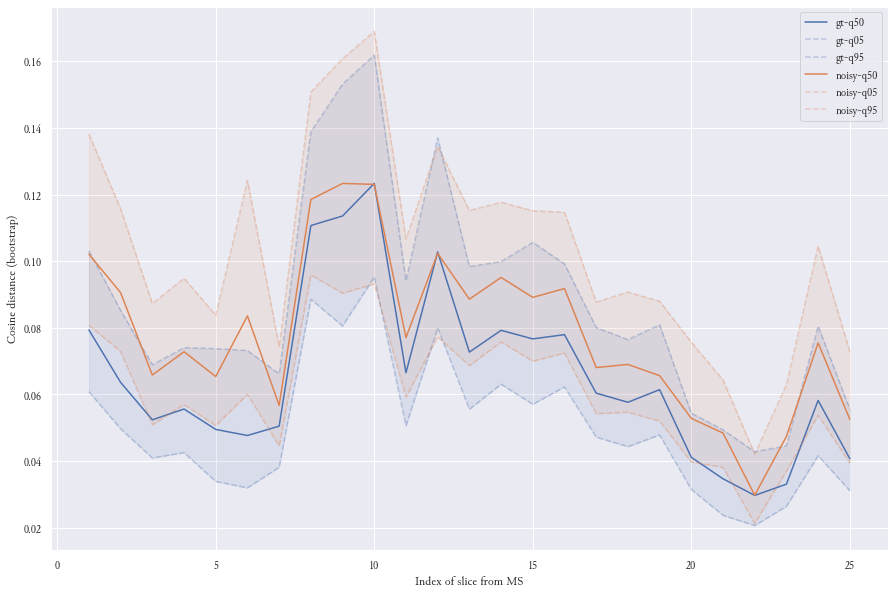

In [185]:
ax = df_result.plot(x='position', y='gt-q50', figsize=(15,10), color='C0')
df_result.plot(x='position', y='gt-q05', ax=ax, color='C0', ls='--', alpha=0.3)
df_result.plot(x='position', y='gt-q95', ax=ax, color='C0', ls='--', alpha=0.3)

df_result.plot(x='position', y='noisy-q50', ax=ax, color='C1')
df_result.plot(x='position', y='noisy-q05', ax=ax, color='C1', ls='--', alpha=0.3)
df_result.plot(x='position', y='noisy-q95', ax=ax, color='C1', ls='--', alpha=0.3)

ax.fill_between(df_result['position'], df_result['gt-q05'], df_result['gt-q95'], color='C0', alpha=0.1);
ax.fill_between(df_result['position'], df_result['noisy-q05'], df_result['noisy-q95'], color='C1', alpha=0.1);

ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from MS');
plt.legend();
plt.savefig('gfx/distance_B_A_noisy.pdf', transparent=False)

### 8.2. Analysis on slices with artificial noise introduced <a name='ablationartificial'/>

In [186]:
# set the number of slices you want to take from the alignment table
num_slices = 25

In [187]:
import numpy as np
import pandas as pd

# read alignment table
df = pd.read_excel("data/alignment_tables/Had_Brieven_A_B_aligned.xlsx")

df.rename(columns = {0:'A', 1:'B'}, inplace = True)

chunks = np.array_split(df, num_slices)

A = []
B = []

for chunk in chunks:
    chunk_a = chunk['A'].tolist()
    chunk_b = chunk['B'].tolist()
    
    chunk_a = [elem for elem in chunk_a if elem != "_"] # delete placeholder when there is no alignment
    chunk_a = [elem for elem in chunk_a if str(elem) != 'nan'] # delete weird NaN artefact (very rare!)
    chunk_b = [elem for elem in chunk_b if elem != "_"]
    chunk_b = [elem for elem in chunk_b if str(elem) != 'nan']
    
    print("A", "\t", len(chunk_a), "\t", "START -", chunk_a[:5], "\n\t\t", "END -", chunk_a[-5:])
    print("B", "\t", len(chunk_b), "\t", "START -", chunk_b[:5], "\n\t\t", "END -", chunk_b[-5:])
    print("----------------")

    A.append(chunk_a)
    B.append(chunk_b)

# flatten list of list of strings to list of strings

A = [' '.join(elem) for elem in A]
B = [' '.join(elem) for elem in B]

A 	 1159 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['ghene', 'ellen', 'de', '.', 'Want']
B 	 1158 	 START - ['GOd', 'die', 'de', 'clare', 'Mᵉ'] 
		 END - ['en', 'gheene', 'ellende', '.', 'Wāt']
----------------
A 	 1183 	 START - ['die', 'dē', 'wille', 'gods', 'kīde'] 
		 END - ['.', 'Der', 'Mⁿ', '.', 'meeste']
B 	 1170 	 START - ['die', 'dē', 'wille', 'gods', 'kinde'] 
		 END - ['noet', 'haddē', 'Der', 'Mⁿ', 'meeste']
----------------
A 	 1167 	 START - ['noet', 'en̄', 'dʼ', 'Mⁿ', '.'] 
		 END - ['doet', 'mi', 'Mᵉ', 'haer', 'wesen']
B 	 1189 	 START - ['noet', 'en̄', 'der', 'mīnē', 'vorste'] 
		 END - ['mi', 'Lᵉ', 'haer', 'wesē', '.']
----------------
A 	 1179 	 START - ['En̄', 'ghichtē', 'die', 'mi', 'vā'] 
		 END - ['node', '.', 'Ter', 'passiē', 'En̄']
B 	 1172 	 START - ['En̄', 'gichtē', 'die', 'mi', 'vā'] 
		 END - ['Jn', 'node', 'Ter', 'passiē', 'En̄']
----------------
A 	 1185 	 START - ['ter', 'doet', 'Jn', 'allē', 'vʼbeide'] 
		 END - ['dech', 'en̄', 'bistierech'

In [188]:
import random

def add_noise(samples, noise_perc=0.05):
    # noise_perc:percentage of characters (non-white space) that will be replaced at random (between 0 and 100%)

    noised = []

    for sample in samples:

        # Get the unique chars that live in a sample, convert the sorted list to a string for convenience
        # We do this to make sure that the variation that is introduced, is reflective of the variation that is already present.
        # For example, an ꝫ will only be added as noise, if this glyph is already present in the text sample before!

        set_chars = sorted(set(sample))
        str_set_chars = ''.join([str(item) for item in set_chars])

        # Get the indexes which are non-whitespace chars
        inds = [i for i,_ in enumerate(sample) if not sample.isspace()]
        #print(f'Number of non-whitespace chars:', len(inds))

        # whole number, reflecting the number of non-whitespace characters that will be replaced at random in the string (based on the noise_perc)
        noise_int = int(len(inds)*noise_perc)
        #print(f'Number chars replaced: {noise_int}')
        #print(f'% of chars replaced (safety check): {(noise_int/len(inds))}, (orig. noise %.: {noise_perc})')

        # These are the positions at which a character will be replaced with a random one (list of ints)
        sam = random.sample(inds, noise_int)

        lst = list(sample)

        for ind in sam:
            lst[ind] = random.choice(str_set_chars)
    
        sample_ = "".join(lst)
    
        noised.append(sample_)
    
    return noised

# clean text samples
A_clean = add_noise(A, noise_perc=0)
B_clean = add_noise(B, noise_perc=0)

# 1% noise
A_noise1 = add_noise(A, noise_perc=0.01)
B_noise1 = add_noise(B, noise_perc=0.01)

# 2% noise
A_noise2 = add_noise(A, noise_perc=0.02)
B_noise2 = add_noise(B, noise_perc=0.02)

# 5% noise
A_noise5 = add_noise(A, noise_perc=0.05)
B_noise5 = add_noise(B, noise_perc=0.05)

# 10% noise
A_noise10 = add_noise(A, noise_perc=0.10)
B_noise10 = add_noise(B, noise_perc=0.10)

# 20% noise
A_noise20 = add_noise(A, noise_perc=0.20)
B_noise20 = add_noise(B, noise_perc=0.20)

# 30% noise
A_noise30 = add_noise(A, noise_perc=0.30)
B_noise30 = add_noise(B, noise_perc=0.30)

# 50% noise
A_noise50 = add_noise(A, noise_perc=0.50)
B_noise50 = add_noise(B, noise_perc=0.50)

In [189]:
len(A_noise20) == len(B_noise20)

True

In [190]:
def feature_extract(A, B):
    # define the number of features to extract
    num_features = 1000 # default: 1000
    vec = CountVectorizer(max_features=num_features, ngram_range=(4, 5), analyzer='char') # char ngram range default: 4, 5
    #vec = TfidfVectorizer(max_features=num_features, use_idf=False, ngram_range=(4, 6), analyzer='char') # char ngram range default: 4, 5
    vec.fit(A + B)
    print(vec.get_feature_names()[:100])
    A_ = vec.transform(A).toarray()
    B_ = vec.transform(B).toarray()
    print(A_.shape, B_.shape)
    return A_, B_

In [191]:
features_clean = feature_extract(A_clean, B_clean)
features_noise1 = feature_extract(A_noise1, B_noise1)
features_noise2 = feature_extract(A_noise2, B_noise2)
features_noise5 = feature_extract(A_noise5, B_noise5)
features_noise10 = feature_extract(A_noise10, B_noise10)
features_noise20 = feature_extract(A_noise20, B_noise20)
features_noise30 = feature_extract(A_noise30, B_noise30)
features_noise50 = feature_extract(A_noise50, B_noise50)

[' . a', ' . d', ' . da', ' . e', ' . en', ' . w', ' al ', ' al d', ' al e', ' all', ' alle', ' allē', ' alr', ' alre', ' als', ' alse', ' also', ' alt', ' alto', ' and', ' ane', ' ane ', ' beg', ' begh', ' beh', ' beho', ' bes', ' bi ', ' bli', ' bou', ' dae', ' daer', ' dan', ' dan ', ' dat', ' dat ', ' de ', ' de m', ' der', ' der ', ' des', ' dese', ' die', ' die ', ' dien', ' dies', ' din', ' dit', ' dit ', ' diē', ' diē ', ' doe', ' doet', ' dog', ' dogh', ' dē ', ' dʼ ', ' dʼ m', ' een', ' en ', ' en s', ' en w', ' end', ' ende', ' ene', ' en̄', ' en̄ ', ' es ', ' es d', ' es e', ' ghe', ' gheb', ' ghee', ' ghel', ' ghem', ' ghen', ' gher', ' ghes', ' gheu', ' ghew', ' ghi', ' ghi ', ' god', ' god ', ' gode', ' gods', ' goe', ' gro', ' hae', ' har', ' hare', ' heb', ' hebb', ' hei', ' heil', ' hem', ' hem ', ' heu', ' heue', ' hi ']
(25, 1000) (25, 1000)
[' . a', ' . d', ' . da', ' . e', ' . en', ' . w', ' al ', ' al d', ' al e', ' all', ' alle', ' alr', ' alre', ' als', ' alse'

#### 8.2.1. Decline of features present in samples <a name='featuredecline'/>

In [192]:
feats_all = []

for text in features_clean:
    for sample in text:
        sum_feats_0 = np.sum(sample)
        feats_all.append(sum_feats_0)

feats_1 = []

for text in features_noise1:
    for sample in text:
        sum_feats_1 = np.sum(sample)
        feats_1.append(sum_feats_1)

feats_2 = []

for text in features_noise2:
    for sample in text:
        sum_feats_2 = np.sum(sample)
        feats_2.append(sum_feats_2)
        
feats_5 = []

for text in features_noise5:
    for sample in text:
        sum_feats_5 = np.sum(sample)
        feats_5.append(sum_feats_5)
        
feats_10 = []

for text in features_noise10:
    for sample in text:
        sum_feats_10 = np.sum(sample)
        feats_10.append(sum_feats_10)
        
feats_20 = []

for text in features_noise20:
    for sample in text:
        sum_feats_20 = np.sum(sample)
        feats_20.append(sum_feats_20)
        
feats_30 = []

for text in features_noise30:
    for sample in text:
        sum_feats_30 = np.sum(sample)
        feats_30.append(sum_feats_30)
        
feats_50 = []

for text in features_noise50:
    for sample in text:
        sum_feats_50 = np.sum(sample)
        feats_50.append(sum_feats_50)

df_feats_all = pd.DataFrame(feats_all, columns =['All features'])
df_feats_1 = pd.DataFrame(feats_1, columns =['1% noise'])
df_feats_2 = pd.DataFrame(feats_2, columns =['2% noise'])
df_feats_5 = pd.DataFrame(feats_5, columns =['5% noise'])
df_feats_10 = pd.DataFrame(feats_10, columns =['10% noise'])
df_feats_20 = pd.DataFrame(feats_20, columns =['20% noise'])
df_feats_30 = pd.DataFrame(feats_30, columns =['30% noise'])
df_feats_50 = pd.DataFrame(feats_50, columns =['50% noise'])

result = pd.concat([df_feats_all, df_feats_1, df_feats_2, df_feats_5, df_feats_10, df_feats_20, df_feats_30, df_feats_50], axis=1).reindex(df_feats_all.index)

result['% of features at 1%'] = (result['1% noise']/ result['All features']) * 100
result['% of features at 2%'] = (result['2% noise']/ result['All features']) * 100
result['% of features at 5%'] = (result['5% noise']/ result['All features']) * 100
result['% of features at 10%'] = (result['10% noise']/ result['All features']) * 100
result['% of features at 20%'] = (result['20% noise']/ result['All features']) * 100
result['% of features at 30%'] = (result['30% noise']/ result['All features']) * 100
result['% of features at 50%'] = (result['50% noise']/ result['All features']) * 100

result

,All features,1% noise,2% noise,5% noise,10% noise,20% noise,30% noise,50% noise,% of features at 1%,% of features at 2%,% of features at 5%,% of features at 10%,% of features at 20%,% of features at 30%,% of features at 50%
0,4069,3905,3745,3370,2664,1794,1077,331,95.969526,92.037356,82.821332,65.470632,44.089457,26.468420,8.134677
1,4378,4179,4061,3549,2941,1778,1183,363,95.454545,92.759251,81.064413,67.176793,40.612152,27.021471,8.291457
2,4307,4169,3987,3457,2863,1885,1067,382,96.795914,92.570235,80.264685,66.473183,43.765962,24.773624,8.869283
3,4120,3956,3801,3318,2750,1774,980,359,96.019417,92.257282,80.533981,66.747573,43.058252,23.786408,8.713592
4,4373,4169,4024,3573,2886,1828,1116,377,95.335010,92.019209,81.705923,65.995884,41.801967,25.520238,8.621084
5,4351,4192,4016,3634,2963,1733,1154,360,96.345668,92.300621,83.521030,68.099288,39.829924,26.522638,8.273960
6,4651,4447,4259,3828,3072,1946,1263,462,95.613846,91.571705,82.304881,66.050312,41.840464,27.155450,9.933348
7,5142,4976,4782,4234,3320,2296,1406,465,96.771684,92.998833,82.341501,64.566317,44.651886,27.343446,9.043174
8,4957,4776,4583,4121,3243,2059,1346,513,96.348598,92.455114,83.134961,65.422635,41.537220,27.153520,10.349001
9,5258,5090,4877,4233,3500,2201,1383,450,96.804869,92.753899,80.505896,66.565234,41.860023,26.302777,8.558387


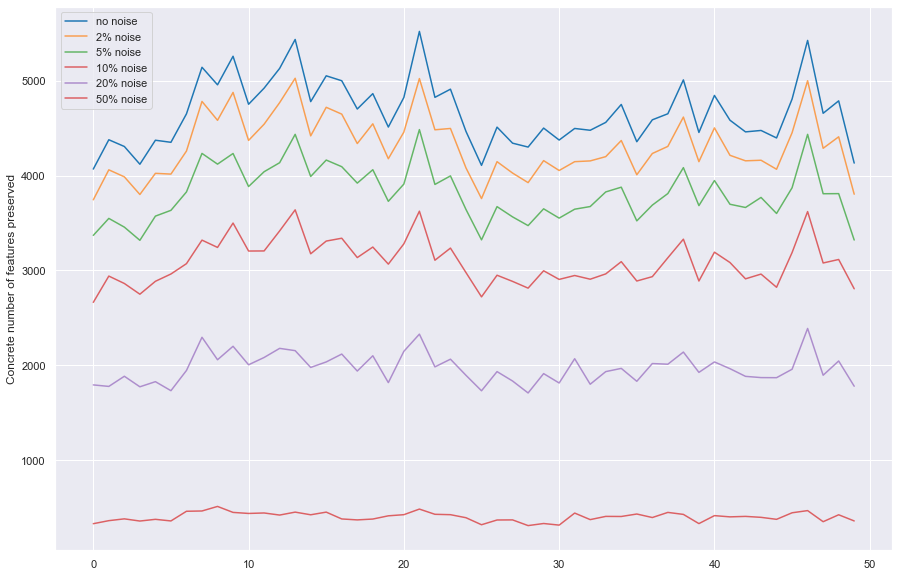

In [194]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = result.plot(y='All features', figsize=(15,10), color='tab:blue', label='no noise')

result.plot(y='2% noise', ax=ax, color='tab:orange', ls='-', alpha=0.7, label='2% noise')
result.plot(y='5% noise', ax=ax, color='tab:green', ls='-', alpha=0.7, label='5% noise')
result.plot(y='10% noise', ax=ax, color='tab:red', ls='-', alpha=0.7, label='10% noise')
result.plot(y='20% noise', ax=ax, color='tab:purple', ls='-', alpha=0.7, label='20% noise')
result.plot(y='50% noise', ax=ax, color='tab:red', ls='-', alpha=0.7, label='50% noise')

ax.set_ylabel('Concrete number of features preserved');

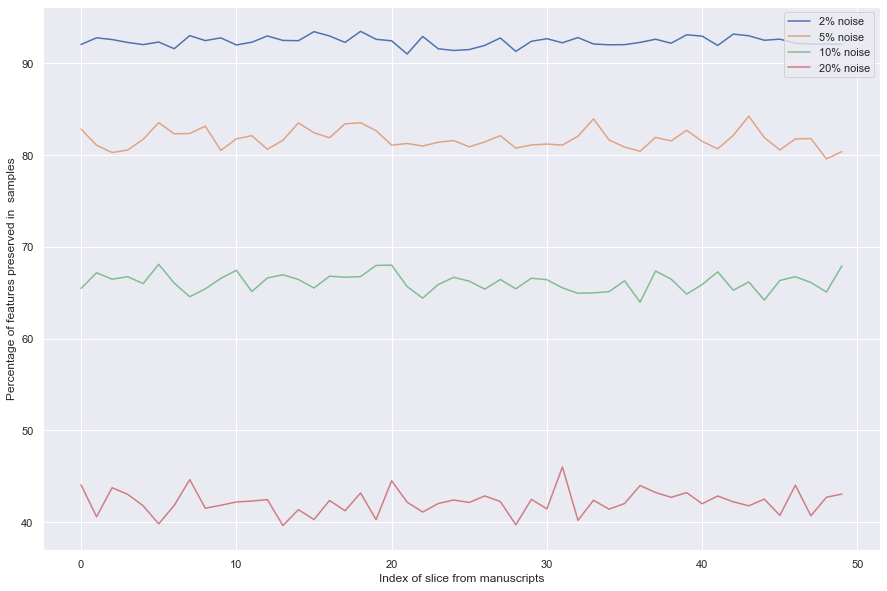

In [195]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = result.plot(y='% of features at 2%', figsize=(15,10), color='C0', label='2% noise')

result.plot(y='% of features at 5%', ax=ax, color='C1', ls='-', alpha=0.7, label='5% noise')
result.plot(y='% of features at 10%', ax=ax, color='C2', ls='-', alpha=0.7, label='10% noise')
result.plot(y='% of features at 20%', ax=ax, color='C3', ls='-', alpha=0.7, label='20% noise')
ax.set_ylabel('Percentage of features preserved in  samples');
ax.set_xlabel('Index of slice from manuscripts');

Text(0.5, 0, 'Index of slice from manuscripts')

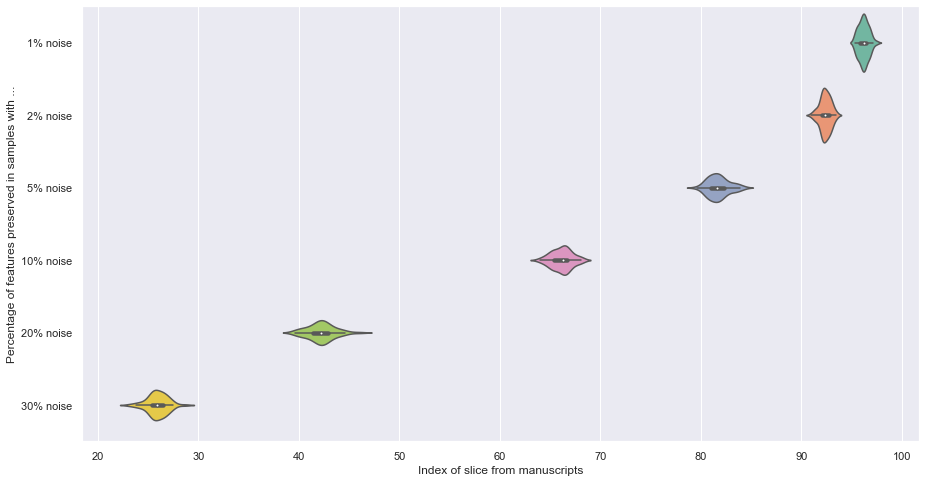

In [196]:
sns.set(rc = {'figure.figsize':(15,8)})
result_concrete = pd.DataFrame(data = result, columns = ['% of features at 1%', '% of features at 2%','% of features at 5%','% of features at 10%', '% of features at 20%', '% of features at 30%'])
ax = sns.violinplot(data=result_concrete, orient="h", palette="Set2")
ax.set_yticklabels(['1% noise', '2% noise','5% noise','10% noise', '20% noise', '30% noise'])
ax.set_ylabel('Percentage of features preserved in samples with ...')
ax.set_xlabel('Index of slice from manuscripts')

#### 8.2.2. Bootstrap on artiificially noisy samples <a name='bootstrapnoised'/>

In [84]:
num_features = 1000

def bootstrap(feats):

    num_boot_features = int(.5 * num_features)
    num_bootstraps = 500 # default: 500
    distances = []

    for idx in tqdm(range(len(feats[0]))):
        d = []
        for _ in range(num_bootstraps):
            rnd_idxs = np.random.choice(range(num_features), size=num_boot_features, replace=False)
            d.append(distance.cosine(feats[0][idx, rnd_idxs], feats[1][idx, rnd_idxs]))
        distances.append((idx + 1,
                          np.quantile(d, 0.05),
                          np.quantile(d, 0.50),
                          np.quantile(d, 0.95)
                         ))
    df = pd.DataFrame(distances, columns=('position', 'q05', 'q50', 'q95'))

    return df


bootstrap_clean = bootstrap(features_clean)

bootstrap1 = bootstrap(features_noise1)
bootstrap2 = bootstrap(features_noise2)
bootstrap5 = bootstrap(features_noise5)
bootstrap10 = bootstrap(features_noise10)
bootstrap20 = bootstrap(features_noise20)
bootstrap30 = bootstrap(features_noise30)
bootstrap50 = bootstrap(features_noise50)

100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


In [190]:
bootstrap1.head()

,position,q05,q50,q95
0,1,0.065031,0.080236,0.106172
1,2,0.051949,0.064028,0.081151
2,3,0.052809,0.072792,0.096543
3,4,0.046542,0.058577,0.074549
4,5,0.045992,0.060009,0.079275


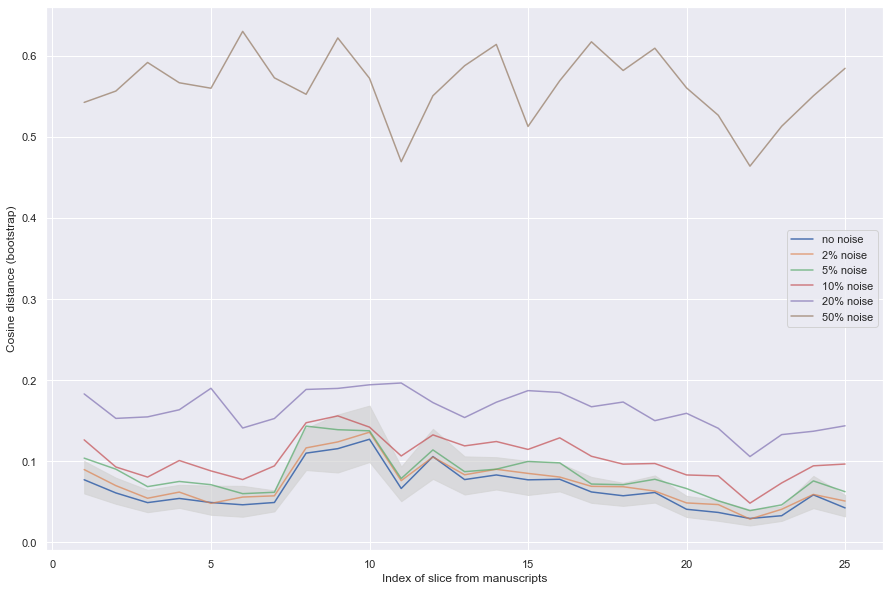

In [197]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = bootstrap_clean.plot(x='position', y='q50', figsize=(15,10), color='C0', label='no noise')

ax.fill_between(bootstrap_clean['position'], bootstrap_clean['q05'], bootstrap_clean['q95'], color='lightgrey', alpha=0.7);

bootstrap2.plot(x='position', y='q50', ax=ax, color='C1', ls='-', alpha=0.7, label='2% noise')
bootstrap5.plot(x='position', y='q50', ax=ax, color='C2', ls='-', alpha=0.7, label='5% noise')
bootstrap10.plot(x='position', y='q50', ax=ax, color='C3', ls='-', alpha=0.7, label='10% noise')
bootstrap20.plot(x='position', y='q50', ax=ax, color='C4', ls='-', alpha=0.7, label='20% noise')
bootstrap50.plot(x='position', y='q50', ax=ax, color='C5', ls='-', alpha=0.7, label='50% noise')



ax.set_ylabel('Cosine distance (bootstrap)');
ax.set_xlabel('Index of slice from manuscripts');
plt.legend();
plt.savefig('gfx/distance_B_A_noised.pdf', transparent=False)

------